# Metadata

```
Course:   DS 5001
Module:   13 Lab
Topic:    Classification with SKLearn's Naive Bayes Classifier.
Author:   R.C. Alvarado
```

# Set Up

In [1]:
data_home = '../data'
data_prefix = 'winereviews'

In [2]:
import pandas as pd
import numpy as np
import plotly_express as px
from sklearn.naive_bayes import CategoricalNB, BernoulliNB

# Get Data

In [49]:
DOCS = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_DOCS.csv").set_index(['doc_id'])
X_TRAIN = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_TRAIN.csv").set_index(['doc_id'])
X_TEST = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}-NB_TEST.csv").set_index(['doc_id'])

# Prepare X and y

In [51]:
y_TRAIN = X_TRAIN.join(DOCS.doc_label).doc_label
y_TEST = X_TEST.join(DOCS.doc_label).doc_label

In [5]:
y_TRAIN.sample(5)

doc_id
73256     N
77046     P
125187    P
92273     N
61491     N
Name: doc_label, dtype: object

In [6]:
y_TEST.sample(5)

doc_id
122039    P
11328     P
12768     N
56478     P
5503      P
Name: doc_label, dtype: object

In [52]:
assert len(X_TRAIN) == len(y_TRAIN)

In [53]:
assert len(X_TEST) == len(y_TEST)

# Fit Model

In [84]:
# BernoulliNB?

In [55]:
clf = BernoulliNB(binarize=None)
clf.fit(X_TRAIN, y_TRAIN)

BernoulliNB(binarize=None)

In [56]:
clf.score(X_TRAIN, y_TRAIN) # The mean accuracy against 10% internal validation set

0.9637776318669293

# Test Model

In [57]:
predictions = clf.predict(X_TEST)

In [58]:
y_PREDICT = pd.Series(predictions, index=X_TEST.index)

In [59]:
y_PREDICT.sample(5)

doc_id
16643     P
99385     N
108124    N
67878     N
32509     P
dtype: object

In [60]:
RESULTS = pd.concat([y_TEST, y_PREDICT], axis=1, keys=['actual','prediction'])

In [61]:
RESULTS

,actual,prediction
doc_id,,
45161,N,N
112275,N,N
30592,P,P
93898,N,N
17278,P,P
...,...,...
21083,P,P
15604,N,N
79896,N,N


In [62]:
RESULTS['result'] = RESULTS.actual == RESULTS.prediction
RESULTS['result_type'] = RESULTS.result.astype('str').str[0] + RESULTS.prediction

In [63]:
RESULTS.sample(10)

,actual,prediction,result,result_type
doc_id,,,,
126130,N,N,True,TN
95389,N,N,True,TN
12705,N,N,True,TN
99504,N,N,True,TN
18213,N,N,True,TN
92029,N,N,True,TN
8885,P,P,True,TP
80810,N,N,True,TN
39327,P,N,False,FN


# Evaluate

In [64]:
RESULTS.result.value_counts()

True     5843
False     249
Name: result, dtype: int64

In [65]:
RESULTS.result_type.value_counts()

TP    2924
TN    2919
FP     158
FN      91
Name: result_type, dtype: int64

In [66]:
RESULTS

,actual,prediction,result,result_type
doc_id,,,,
45161,N,N,True,TN
112275,N,N,True,TN
30592,P,P,True,TP
93898,N,N,True,TN
17278,P,P,True,TP
...,...,...,...,...
21083,P,P,True,TP
15604,N,N,True,TN
79896,N,N,True,TN


## Confusion Matrix

In [67]:
CM = RESULTS.reset_index().groupby(['prediction','actual']).doc_id.count().unstack().fillna(0)

In [68]:
CM

actual,N,P
prediction,,
N,2919,91
P,158,2924


In [69]:
def show_results(M):
    
    R = M.groupby('result_type').result_type.count().T
    
    print(R)
    print()

    # TP:  hits
    # FP:  Type I errors; false alarms
    # TN:  correct rejections
    # FN:  Type  II errors; misses
    # ACC: Accuracy
    # TPR: True Positive Rate, Recall, Sensitivity
    # TNR: True Negative Rate, Specificity
    # PPV: Positive Predictive Value, Precision
    # BA:  Balanced Accuracy
    # F1:  F-score where F = 1

    T = R.TP + R.TN
    F = R.FP + R.FN
    ALL =  T + F

    ACC = T / ALL
    TPR = R.TP / (R.TP + R.FN)
    TNR = R.TN / (R.TN + R.FP)
    PPV = R.TP / (R.TP + R.FP)
    BA = (TNR + TPR) / 2
    F1 = (2 *  R.TP) / (2 * R.TP + R.FP + R.FN)

    assert ALL == R.sum()

    print('TPR:', round(TPR, 2), '(sensitivity)')
    print('TNR:', round(TNR, 2), '(specificity)')
    print('F1: ', round(F1, 2), '<-- GRADE')
    print('PPV:', round(PPV, 2),  '(precision)')
    print('ACC:', round(ACC, 2), '(accuracy)')        

In [70]:
show_results(RESULTS)

result_type
FN      91
FP     158
TN    2919
TP    2924
Name: result_type, dtype: int64

TPR: 0.97 (sensitivity)
TNR: 0.95 (specificity)
F1:  0.96 <-- GRADE
PPV: 0.95 (precision)
ACC: 0.96 (accuracy)


# Explore

In [71]:
LIKELIHOODS = pd.DataFrame(clf.feature_log_prob_, index=clf.classes_, columns=clf.feature_names_in_).T
LIKELIHOODS.index.name = 'term_str'

In [72]:
SALEX = (np.sign(LIKELIHOODS['P'] - LIKELIHOODS['N'])).to_frame('polarity')
SALEX['valence'] = (LIKELIHOODS['P'] - LIKELIHOODS['N'])

In [73]:
SALEX.describe()

,polarity,valence
count,4000.000000,4000.000000
mean,0.409000,0.620507
std,0.912648,1.432683
min,-1.000000,-4.843065
25%,-1.000000,-0.160934
50%,1.000000,0.686364
75%,1.000000,1.551361
max,1.000000,5.700327


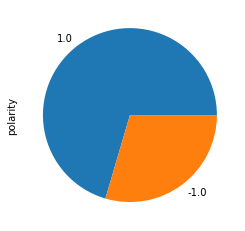

In [74]:
SALEX.polarity.value_counts().plot(kind='pie');

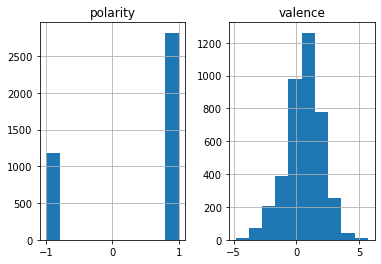

In [75]:
SALEX.hist();

## Top Positive Words

In [76]:
SALEX.sort_values('valence', ascending=False).head(20)

,polarity,valence
term_str,,
2025,1.0,5.700327
2022,1.0,5.680192
2030,1.0,5.561561
2023,1.0,5.335551
2024,1.0,5.146508
decade,1.0,5.062121
gorgeous,1.0,4.931281
superb,1.0,4.845247
2021,1.0,4.821530


## Top negative words

In [77]:
SALEX.sort_values('valence', ascending=True).head(20)

,polarity,valence
term_str,,
everyday,-1.0,-4.843065
easygoing,-1.0,-4.843065
informal,-1.0,-4.269463
dull,-1.0,-4.255279
dilute,-1.0,-4.181171
watery,-1.0,-4.133918
simple,-1.0,-4.106243
bland,-1.0,-3.977075
pizza,-1.0,-3.898604


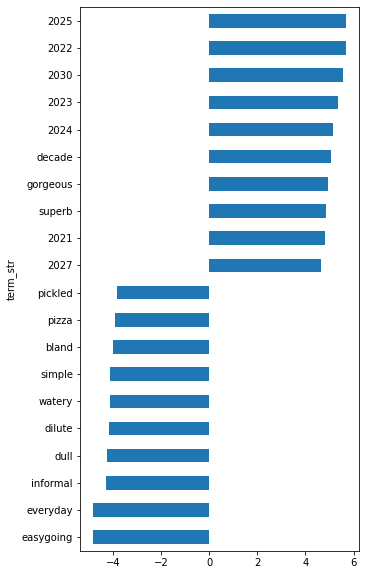

In [78]:
wpos = SALEX.valence.sort_values(ascending=False).head(10)
wneg = SALEX.valence.sort_values(ascending=True).head(10)
pd.concat([wpos,wneg]).sort_values().plot.barh(figsize=(5,10));

# Save

In [79]:
SALEX.to_csv(f'{data_home}/{data_prefix}/{data_prefix}-NB_SK_SALEX.csv')
RESULTS.to_csv(f'{data_home}/{data_prefix}/{data_prefix}-NB_SK_RESULTS.csv')